Visualizing property crime frequencies

In [1]:
# pip install opencv-python
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in crime data (years 2013 to 2017)
crimes_data = pd.read_csv('../vara_2.csv', delimiter='\t')
# We drop 2017 data, because the administrative reform changed the municiaplities map
crimes_data = crimes_data[~crimes_data['ToimKpv'].str.startswith("2017")]
# Drop rows which don't have information about municipality
crimes_data = crimes_data[~crimes_data['ValdLinnNimetus'].isnull()]
# Replace: "Tallinna linn" - "Tallinn"
crimes_data['ValdLinnNimetus'] = crimes_data['ValdLinnNimetus'].replace('Tallinna linn', 'Tallinn')
# Replace: "Tartu linn (ls)" - "Tartu linn"
crimes_data['ValdLinnNimetus'] = crimes_data['ValdLinnNimetus'].replace('Tartu linn (ls)', 'Tartu linn')
# Deleted "!Sisestamata"
crimes_data = crimes_data[crimes_data['ValdLinnNimetus'] != '!Sisestamata']

# Replacing cities which are not on the map with their municipality
# In population data the cities (which are not their own municipality) are included anyway
municiplaity_names_replacements = [
    ('Jõhvi linn', 'Jõhvi vald'),
    ('Tapa linn', 'Tapa vald'),
    ('Rapla linn', 'Rapla vald'),
    ('Põlva linn', 'Põlva vald'),
    ('Türi linn', 'Türi vald'),
    ('Kehra linn', 'Anija vald'),
    ('Tamsalu linn', 'Tamsalu vald'),
    ('Räpina linn', 'Räpina vald'),
    ('Lihula linn', 'Lihula vald'),
    ('Kilingi-Nõmme linn', 'Saarde vald'),
    ('Otepää linn', 'Otepää vald'),
    ('Karksi-Nuia linn', 'Karksi vald'),
    ('Antsla linn', 'Antsla vald'),
    ('Abja-Paluoja linn', 'Abja vald'),
    ('Suure-Jaani linn', 'Suure-Jaani vald')
]

for replacement in municiplaity_names_replacements:
    crimes_data['ValdLinnNimetus'] = crimes_data['ValdLinnNimetus'].replace(replacement[0], replacement[1])
    
# Removing some places which are not on the map
# Most of these are places which merged into some other municipality during the years 2013 - 2016
# Note: the map is from the end of 2016
places_to_remove = [
    'Püssi linn', # Lüganuse vald
    'Taebla vald', # Lääne-Nigula vald
    'Pärsti vald', # Viljandi vald
    'Kõue vald', # Ühines Kose vallaga
    'Kaarma vald', # Lääne-Saare vald
    'Viiratsi vald', # Viljandi vald
    'Kärla vald', # Lääne-Saare vald
    'Lümanda vald', # Lääne-Saare vald
    'Paistu vald', # Viljandi vald
    'Saarepeedi vald', # Viljandi vald
    'Maidla vald', # Lüganuse vald
    'Kõrgessaare vald', # Hiiu vald
    'Risti vald', # Lääne-Nigula vald
    'Oru vald', # Lääne-Nigula vald
    'Valga vald', # Moodustatud 2017
    'Lavassaare vald', # Ühines Audru vallaga
    'Saaremaa vald' # Moodustatud 2017
]

for place in places_to_remove:
    crimes_data = crimes_data[crimes_data['ValdLinnNimetus'] != place]
    
# Read in municipalities population data
# Dataset source: andmebaas.stat.ee/Index.aspx?lang=et&DataSetCode=RV0291
# Note: only some of the values from the dataset on that page are selected and some column
#  names have been changed
population_data = pd.read_csv('omavalitsuste_rahvaarv.csv')
# Removing ".." from the municipalities names, which came from the dataset
population_data['Omavalitsus'] = population_data['Omavalitsus'].map(lambda x: x[2:])

# Read in municipalities population density data
# Dataset source (same as for population): andmebaas.stat.ee/Index.aspx?lang=et&DataSetCode=RV0291
# Note: only some of the values from the dataset on that page are selected and some column
#  names have been changed
density_data = pd.read_csv('omavalitsuste_asustustihedus.csv')
# Removing ".." from the municipalities names, which came from the dataset
density_data['Omavalitsus'] = density_data['Omavalitsus'].map(lambda x: x[2:])

In [3]:
# Crime count relative to the population
crimes_freq = {}
# List of municipalities crime rates and densities - will be neede later for plotting
crimes_freq_and_density = []

for municipality in crimes_data['ValdLinnNimetus'].unique():
    crime_rates_in_years = []
    density_in_years = []
    for year in range(2013, 2017):
        pop_row = population_data[(population_data['Vaatlusperiood'] == year) & (population_data['Omavalitsus'] == municipality)]
        # Some municipalities didn't exist yet/anymore at certain years
        if len(pop_row) == 1:
            year_pop = pop_row['Rahvaarv'].iloc[0]
            year_crimes = crimes_data[(crimes_data['ValdLinnNimetus'] == municipality)
                                      & (crimes_data['ToimKpv'].str.startswith(str(year)))].shape[0]
            crime_rates_in_years.append(year_crimes / year_pop)
            density_row = density_data[(density_data['Vaatlusperiood'] == year) & (density_data['Omavalitsus'] == municipality)]
            year_density = density_row['Asustustihedus, elanikku km2 kohta'].iloc[0]
            density_in_years.append(year_density)
    # For better readability we multiple the rate by 1000
    average_crime_rate = (sum(crime_rates_in_years) / len(crime_rates_in_years)) * 1000
    average_density = sum(density_in_years) / len(density_in_years)
    crimes_freq[municipality] = average_crime_rate
    crimes_freq_and_density.append((average_crime_rate, average_density))

In [4]:
def get_municipality_pixel_coords():
    municipality_coords = {}
    file = open('municipality_pixel_coords.txt', 'r')
    lines = file.readlines()
    for line in lines:
        line = line.strip('\n')
        municipality, coords = line.split(': ')
        coords = coords.split("; ")
        coords_list = []
        for coord in coords:
            coord = coord.strip('()')
            coord_x, coord_y = coord.split(', ')
            coords_list.append((int(coord_x), int(coord_y)))
        municipality_coords[municipality] = coords_list
    file.close()
    return municipality_coords

# Pixel coordinates which are used for coloring the municiaplities with the floodfill tool
municipality_coords = get_municipality_pixel_coords()

In [5]:
def read_img(name):
    return cv.imread(name)

def save_img(img, name):
    cv.imwrite(name, img)

# Debugimiseks
def show_img(img):
    cv.imshow('', img)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
def show_img_inline(input_img):
    # Need to reverse the colors again
    img = input_img.copy()
    for i in range(len(input_img)):
        for j in range(len(input_img[i])):
            input_colors = input_img[i][j]
            img[i][j] = [input_colors[2], input_colors[1], input_colors[0]]
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()

def floodfill(img, coord, colorIn):
    (r, g, b) = colorIn
    color = (b, g, r) # cv.floodFill function has colors in reverse
    img = img.copy()
    cv.floodFill(img, None, coord, color)
    return img

def color_municipality(img, municipality, color):
    img = img.copy()
    for coord in municipality_coords[municipality]:
        img = floodfill(img, coord, color)
    return img

In [6]:
# max amount of crimes per 1000 people per year : rgb color
heat_ranges = {
    5: (233, 239, 191),
    10: (248, 196, 22),
    15: (245, 131, 32),
    20: (241, 96, 39),
    25: (234, 38, 42),
    1000: (161, 30, 36)
}

img = read_img('est_map_municipalities.png')
c = crimes_freq
for mun, val in c.items():
    col = None
    for x, y in heat_ranges.items():
        if val < x:
            col = y
            break
    img = color_municipality(img, mun, col)
save_img(img, 'crime_rate_heatmap.png')

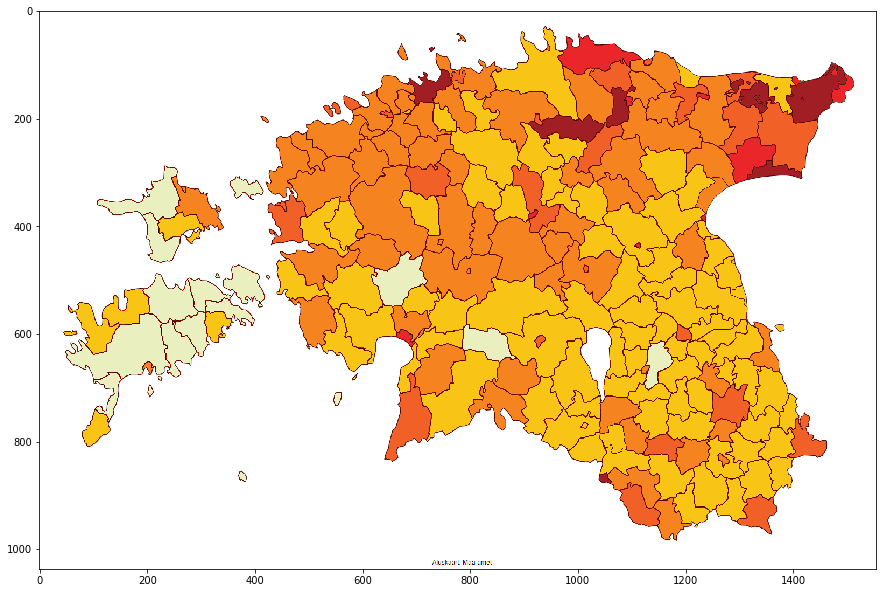

In [7]:
show_img_inline(img)
# Legend will be added later manually

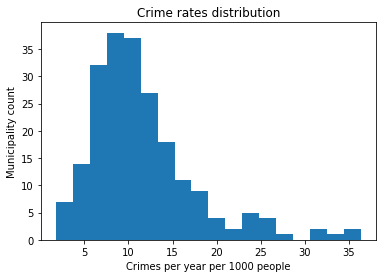

In [8]:
# Making a histogram of the crime rates
fig = plt.figure()
plt.hist(list(crimes_freq.values()), bins='auto')
plt.title('Crime rates distribution')
plt.xlabel('Crimes per year per 1000 people')
plt.ylabel('Municipality count')
plt.show()
fig.savefig('crime_rates_distribution.png')

In [9]:
# Getting the places with the highest and lowest crime rates
crimes_freqs_sorted = sorted(crimes_freq.items(), key = lambda v: v[1], reverse = True)
print('Municipalities with highest amount of property crimes per 1000 people:')
for i in range(5):
    entry = crimes_freqs_sorted[i]
    print(str(i + 1) + '. ' + entry[0] + ': ' + str(round(entry[1], 2)))
print()
print('Municipalities with lowest amount of property crimes per 1000 people:')
for i in range(5):
    entry = crimes_freqs_sorted[-(i + 1)]
    print(str(i + 1) + '. ' + entry[0] + ': ' + str(round(entry[1], 2)))
print()
print('Tartu\'s property crime rate: ' + str(crimes_freq['Tartu linn']))

Municipalities with highest amount of property crimes per 1000 people:
1. Vaivara vald: 36.31
2. Rakvere vald: 35.11
3. Jõhvi vald: 33.86
4. Narva-Jõesuu linn: 31.25
5. Tallinn: 30.84

Municipalities with lowest amount of property crimes per 1000 people:
1. Ruhnu vald: 1.81
2. Hiiu vald: 2.35
3. Salme vald: 2.85
4. Muhu vald: 3.37
5. Pöide vald: 3.45

Tartu's property crime rate: 17.578886598167568


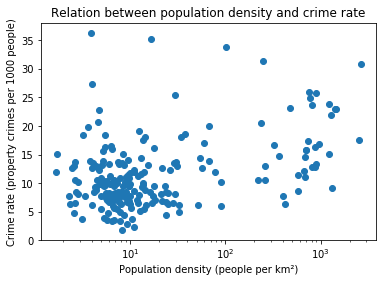

 Pearson correlation coefficient: 0.42


In [10]:
# Plotting crime rates agains population density
x_data = []
y_data = []
for y, x in crimes_freq_and_density:
    x_data.append(x)
    y_data.append(y)
fig = plt.figure()
plt.scatter(x_data, y_data)
plt.title('Relation between population density and crime rate')
plt.xlabel('Population density (people per km²)')
plt.ylabel('Crime rate (property crimes per 1000 people)')
# Well use logarithmic scale, because the density differences are quite big
plt.xscale('log')
plt.show()
fig.savefig('population_density_and_crime_rate.png')

corr = np.corrcoef(x_data, y_data)[0, 1]
print(' Pearson correlation coefficient: ' + str(round(corr, 2)))